In [1]:
import numpy as np
from scipy.integrate import ode

from matplotlib import pyplot as plt


We define the membrane equation :

$\tau_m \frac{d}{dt} V(t) = E_L- V(t) + R I(t) $ if $V(t) \leq V_{th}$

$V(t) = V_{reset}$ + record a spike otherwise




In [ ]:
# We also compute the distribution of the potential following a random synaptic input for a fixed time t_k 

t_k = t_max/10
t_k_I = t_max

k = int(np.where(np.round(t_list,4) == t_k)[0])
k_I = int(np.where(np.round(t_list,4) == t_k_I)[0])


Vk = Vt_j[:,k]
Vk_I = Vt_j[:,k_I]


nbins = 50
plt.hist(Vk, nbins)
plt.hist(Vk_I, nbins)


In [7]:
class LIF_model:
    
    def __init__(self, N, E_l=-60e-3, V_r=-70e-3 , V_th=-50e-3, R=100e6, I_mean=25e-11, tau_m=20e-3, Delta = 0.1 ):

        self.N = N        
        self.E_l = E_l        
        self.V_reset = V_r       
        self.V_th = V_th        
        self.R = R        
        
        
        self.I_mean = I_mean        
        self.tau_m = tau_m
        self.Delta = Delta
    
    
    def rhs(t, V, tau_m, E_l, R, I):
        return 1/tau_m*(E_l - V + R*I)
  
    
    def I_rand(self, I_mean, Delta, tmax, dt):
        return I_mean*(1+ Delta*np.sqrt(tmax/dt) * (2*np.random.rand() -1) )

                   
    def Vt(self, t_max, dt , mu, sigma):
        
        n_reals = self.N
        res = ode(rhs).set_integrator('zvode', method='bdf')

        Vt_j = self.E_l*np.ones((n_reals, int(t_max/dt)))

        spike_times =  [ [] for j in range(n_reals)]
        spike_occurrence = np.zeros(int(t_max/dt))

        # Initialize t_ref
        mu=0.01
        sigma=0.007
        t_ref = mu + sigma*np.random.normal(size=n_reals)

        #Initial conditions
        t_list = []
        t=0
        res.set_initial_value(self.E_l, dt)
        to_iterate = list(range(n_reals))
        to_restore = []

        
        while res.successful() and res.t < t_max+dt:
            t_list.append(res.t)
            spike_index=[]
    
            for tt in range(n_reals): #Here we re-introduce the neurons in the loop
                if tt not in to_iterate and t_list[-1] >= spike_times[tt][-1]+t_ref[tt]: #If the refractory period is passed
                    to_iterate.append(tt)
                    to_iterate.sort()

            if len(to_iterate)==0: res.t = res.t+dt #The evolution advances if all the neurons have spiked
    
            else:
                for p in to_iterate:
                    res.set_initial_value(Vt_j[p,t-1], t_list[t]) #Initial conditions   
                    It = self.I_rand(self.I_mean, self.Delta, t_max, dt) #Set the input
                    res.set_f_params(self.tau_m, self.E_l, self.R, It) #Set the input
                    Vt_j[p,t] = np.real(res.integrate(t_list[t]+dt)[0]) #Solves the differential equation
        
           
                    if Vt_j[p,t] >= self.V_th :  #If p-th neuron spikes
                        spike_times[p].append(t_list[t]) 
                        spike_occurrence[t] = spike_occurrence[t]+1
                        to_iterate.remove(p)
    
            if len(to_iterate) < n_reals: #If some neurons is resting 
                indxs = [k for k in list(range(n_reals)) if k not in to_iterate] #Get the index of the spikes
                Vt_j[indxs,t] = self.V_reset #Set the potential to the reset value
                res.set_initial_value(self.V_reset, t_list[t]+dt) #reset the initial conditions

            t = t+1
        
        return Vt_j, spike_times, spike_occurrence

    def mean_qnts(self, Vt_j, spike_occurrence):
        V_mean = 1/self.N*np.einsum('ij->j', Vt_j)
        spike_rate = spike_occurrence/self.N

        return V_mean, spike_rate


    
    
    

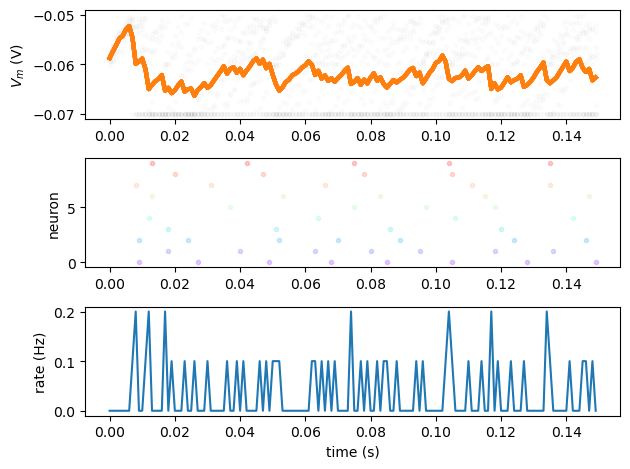

In [8]:
t_max=150e-3
dt=1e-3

lif = LIF_model(10)

Vt_j, spike_times, spike_occurrence = lif.Vt(t_max,dt,mu,sigma)
V_mean, spike_rate = lif.mean_qnts(Vt_j, spike_occurrence)



# Figures
t_list =np.arange(0,t_max,dt)
n_reals = lif.N

plt.figure()

# Plot simulations and sample mean
ax1 = plt.subplot(3, 1, 1)
for j in range(lif.N):
    plt.scatter(t_list, Vt_j[j], color="k", marker=".", alpha=0.01)
    plt.plot(t_list, V_mean, 'C1', alpha=0.8, linewidth=3)
    plt.ylabel('$V_m$ (V)')

    
# Plot spikes
plt.subplot(3, 1, 2, sharex=ax1)
colors = plt.cm.rainbow(np.linspace(0, 1, n_reals))


# for each neuron j: collect spike times and plot them at height j
for j in range(lif.N):
    times = np.array(spike_times[j])
    plt.scatter(times, j * np.ones_like(times), color=colors[j], marker=".", alpha=0.2)


plt.ylabel('neuron')

# Plot firing rate
plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(t_list, spike_rate)
plt.xlabel('time (s)')
plt.ylabel('rate (Hz)')

plt.tight_layout()
